In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
from torch.utils.data import random_split
from torch.nn.modules.activation import Softmax
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torchinfo import summary

In [2]:
# from google.colab import drive
#
# drive.mount('/content/drive')

In [3]:
# root = '/content/drive/MyDrive/Colab Notebooks/CS520/CIS Final Project/data/'
root = '../data/'
os.chdir(root)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


In [5]:
# Convert images to tensors and add labels

real_cats_dir = os.path.join(root, 'real')
generated_cats_dir = os.path.join(root, 'generated_')

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean = [0,0,0],
    #                      std= [0.5,0.5,0.5])
])


def get_images(dir, label):
    images = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        if os.path.isfile(f):
            img = Image.open(f)
            images.append((transform(img), label))
    return images


# label 0 indicates real image
real_images = get_images(real_cats_dir, 0)
# label 1 indicates AI image
generated_images = get_images(generated_cats_dir, 1)

# Combine real and generated for full dataset
full_dataset = real_images + generated_images
random.shuffle(full_dataset)

In [6]:
# Split into training and testing sets
train_size = int(0.8 * len(full_dataset))
test_size = int((len(full_dataset) - train_size) * .1)
val_size = len(full_dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(full_dataset, [train_size, test_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

images, labels = next(iter(train_loader))

torch.Size([32, 3, 256, 256])


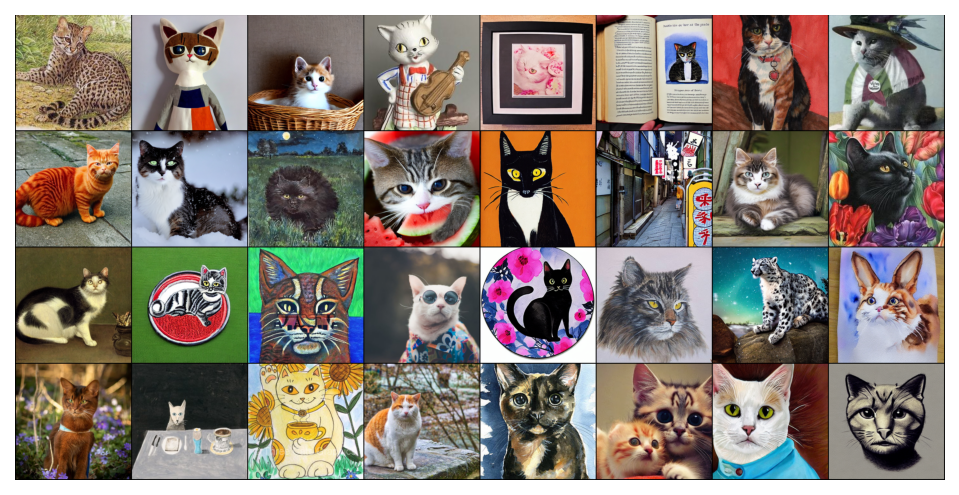

In [7]:
def imshow(img):
    img = img
    npimg = img.numpy()
    figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [8]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.flatten = torch.nn.Flatten()

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(69696, 1028),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)(x)

        x = self.conv2(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)(x)

        x = self.conv3(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)(x)

        x = self.flatten(x)
        x = self.fc(x)
        return x


encoder = Encoder()
encoder_net = encoder.to(device)
summary(encoder_net, input_size=(32, 3, 256, 256), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [32, 1028]                --
├─Sequential: 1-1                        [32, 32, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        2,432
│    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
│    └─ReLU: 2-3                         [32, 32, 256, 256]        --
├─Sequential: 1-2                        [32, 32, 129, 129]        --
│    └─Conv2d: 2-4                       [32, 32, 129, 129]        25,632
│    └─BatchNorm2d: 2-5                  [32, 32, 129, 129]        64
│    └─ReLU: 2-6                         [32, 32, 129, 129]        --
├─Sequential: 1-3                        [32, 64, 65, 65]          --
│    └─Conv2d: 2-7                       [32, 64, 65, 65]          51,264
│    └─BatchNorm2d: 2-8                  [32, 64, 65, 65]          128
│    └─ReLU: 2-9                         [32, 64, 65, 65]          --
├─F

In [9]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.conv1_decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, padding=2, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.conv2_decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, padding=2, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.conv3_decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, padding=2, output_padding=0),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 33, 33))

        self.fc_decoder = nn.Sequential(
            nn.Linear(1028, 69696),
            nn.ReLU()
        )
        self.up1 = nn.Upsample((65, 65))
        self.up2 = nn.Upsample((129, 129))
        self.up3 = nn.Upsample((256, 256))
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc_decoder(x)
        x = self.unflatten(x)

        x = self.up1(x)
        x = self.conv1_decoder(x)

        x = self.up2(x)
        x = self.conv2_decoder(x)

        x = self.up3(x)
        x = self.conv3_decoder(x)

        x = self.sig(x)
        return x


decoder = Decoder()
decoder_net = decoder.to(device)
summary(decoder_net, input_size=(32, 1028), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 69696]               --
│    └─Linear: 2-1                       [32, 69696]               71,717,184
│    └─ReLU: 2-2                         [32, 69696]               --
├─Unflatten: 1-2                         [32, 64, 33, 33]          --
├─Upsample: 1-3                          [32, 64, 65, 65]          --
├─Sequential: 1-4                        [32, 32, 65, 65]          --
│    └─ConvTranspose2d: 2-3              [32, 32, 65, 65]          51,232
│    └─ReLU: 2-4                         [32, 32, 65, 65]          --
│    └─BatchNorm2d: 2-5                  [32, 32, 65, 65]          64
├─Upsample: 1-5                          [32, 32, 129, 129]        --
├─Sequential: 1-6                        [32, 32, 129, 129]        --
│    └─ConvTranspose2d: 2-6              [32, 32, 129, 129]        25,632

In [10]:
epochs = 128
criterion = nn.MSELoss()  # use MSE for AE reconstruction error  #nn.CrossEntropyLoss()
params = [
    {'params': encoder_net.parameters()},
    {'params': decoder_net.parameters()}
]
optimizer = optim.Adam(params, lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_ = []
val_loss_ = []
encoder_net.train()
decoder_net.train()

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0
    val_running_loss = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        encoded_data = encoder_net(inputs)
        decoded_data = decoder_net(encoded_data)
        loss = criterion(decoded_data, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # if (epoch + 1) % 4 == 0 or epoch == 0:
        # with torch.no_grad():
        #   correct = 0
        #   total = 0
        #   for i, data in enumerate(val_loader, 0):
        #     inputs, labels = data
        #     inputs = inputs.to(device)
        #     labels = labels.to(device)

        #     outputs = net(inputs)

        #     _, predicted = torch.max(outputs.data, 1)

        #     val_loss = criterion(predicted.float(), labels)
        #     val_running_loss += val_loss.item()

        #     correct += predicted.eq(labels.reshape(len(labels),)).sum()
        #     total += float(len(labels))

        # accuracy = correct / total
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            val_X = inputs.to(device)
            val_X_hat = decoder_net(encoder_net(val_X))
            val_loss = criterion(val_X_hat, val_X)
            val_running_loss += val_loss.item()
    scheduler.step(val_running_loss)

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.4f}, Validation Loss: {val_running_loss:.4f}')
    loss_.append(running_loss)
    val_loss_.append(val_running_loss)

print('Finished Training')

Epoch: 1, Loss: 15.6912, Validation Loss: 2.8436
Epoch: 2, Loss: 11.3801, Validation Loss: 2.5151
Epoch: 3, Loss: 10.1829, Validation Loss: 2.1465
Epoch: 4, Loss: 8.8496, Validation Loss: 2.0298
Epoch: 5, Loss: 8.3838, Validation Loss: 1.9569
Epoch: 6, Loss: 8.0707, Validation Loss: 1.9017
Epoch: 7, Loss: 7.8499, Validation Loss: 1.8766
Epoch: 8, Loss: 7.6934, Validation Loss: 1.8034
Epoch: 9, Loss: 7.6253, Validation Loss: 1.7947
Epoch: 10, Loss: 7.4940, Validation Loss: 1.7767
Epoch: 11, Loss: 7.4199, Validation Loss: 1.7492
Epoch: 12, Loss: 7.4066, Validation Loss: 1.8118
Epoch: 13, Loss: 7.3394, Validation Loss: 1.7712
Epoch: 14, Loss: 7.2652, Validation Loss: 1.7314
Epoch: 15, Loss: 7.2366, Validation Loss: 1.7367
Epoch: 16, Loss: 7.2413, Validation Loss: 1.7871
Epoch: 17, Loss: 7.1424, Validation Loss: 1.6680
Epoch: 18, Loss: 7.1023, Validation Loss: 1.6973
Epoch: 19, Loss: 7.0630, Validation Loss: 1.7343
Epoch: 20, Loss: 7.0598, Validation Loss: 1.6773
Epoch: 21, Loss: 7.0535, V

In [11]:
torch.save(encoder_net, "ae_encoder.pt")
torch.save(decoder_net, "ae_decoder.pt")

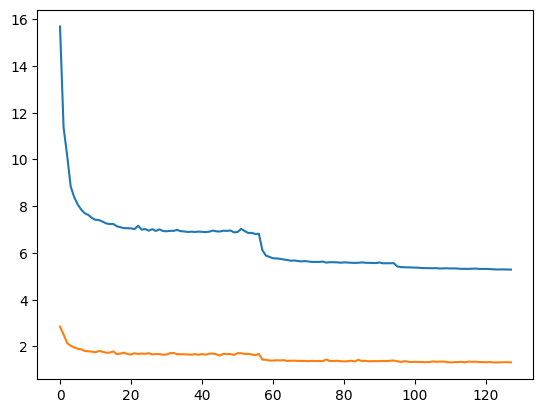

In [13]:
x = [i for i in range(0, epochs)]
plt.plot(x, loss_)
plt.plot(x, val_loss_)

torch.Size([32, 3, 256, 256])


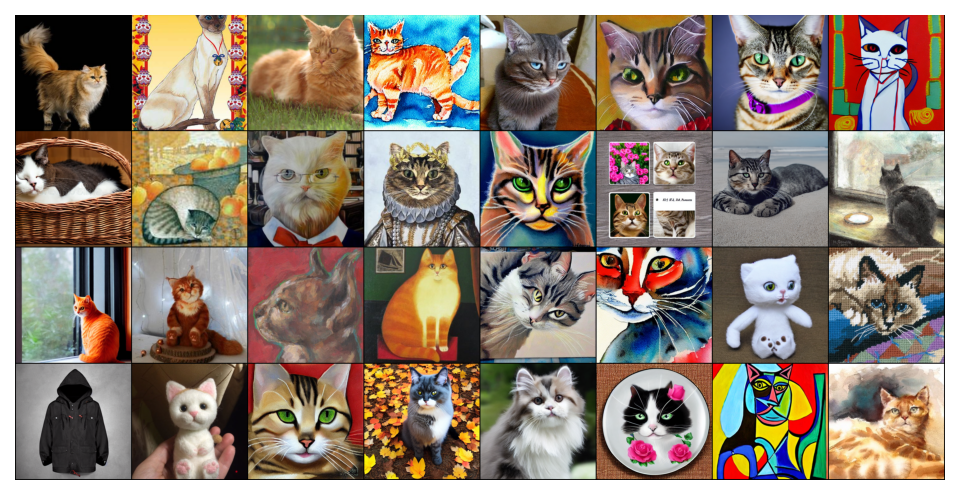

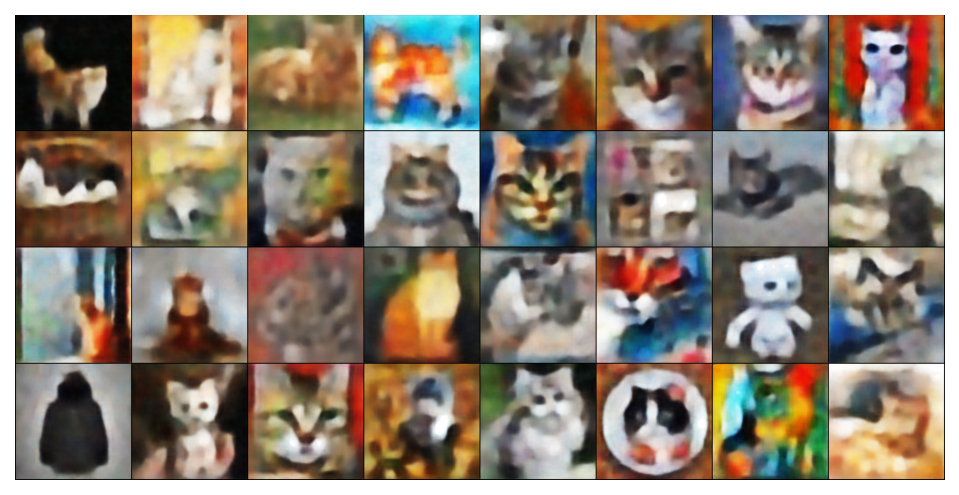

In [14]:
encoder_net.eval()
decoder_net.eval()
# get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# predict images
recoded_images = decoder_net(encoder_net(images.to(device))).cpu()
imshow(torchvision.utils.make_grid(recoded_images))

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(1028, 512),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(512, 64),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.fc(x)
        return x


net = Net()
net = net.to(device)
summary(net, input_size=(32, 1028), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 2]                   --
│    └─Linear: 2-1                       [32, 512]                 526,848
│    └─ReLU: 2-2                         [32, 512]                 --
│    └─Dropout: 2-3                      [32, 512]                 --
│    └─Linear: 2-4                       [32, 64]                  32,832
│    └─ReLU: 2-5                         [32, 64]                  --
│    └─Dropout: 2-6                      [32, 64]                  --
│    └─Linear: 2-7                       [32, 2]                   130
Total params: 559,810
Trainable params: 559,810
Non-trainable params: 0
Total mult-adds (M): 17.91
Input size (MB): 0.13
Forward/backward pass size (MB): 0.15
Params size (MB): 2.24
Estimated Total Size (MB): 2.52

In [16]:
epochs = 64
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_ = []
val_loss_ = []
encoder_net.eval()

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0
    val_running_loss = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        encoded_data = encoder_net(inputs)
        predictions = net(encoded_data)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(encoder_net(inputs))
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(labels.reshape(len(labels),)).sum()
            total += float(len(labels))
    scheduler.step(val_running_loss)
    accuracy = correct / total

    print(f'Epoch: {epoch+1}, Loss: {running_loss:.4f}, Validation Loss: {val_running_loss:.4f}, Validation Acc.: {accuracy:.4f}')
    loss_.append(running_loss)
    val_loss_.append(val_running_loss)

print('Finished Training')

Epoch: 1, Loss: 174.4281, Validation Loss: 37.8946, Validation Acc.: 0.7185
Epoch: 2, Loss: 155.6136, Validation Loss: 36.6421, Validation Acc.: 0.7134
Epoch: 3, Loss: 149.3555, Validation Loss: 34.3151, Validation Acc.: 0.7446
Epoch: 4, Loss: 143.0991, Validation Loss: 33.7549, Validation Acc.: 0.7521
Epoch: 5, Loss: 140.9124, Validation Loss: 34.0871, Validation Acc.: 0.7554
Epoch: 6, Loss: 138.1746, Validation Loss: 32.6630, Validation Acc.: 0.7596
Epoch: 7, Loss: 137.1748, Validation Loss: 34.7787, Validation Acc.: 0.7390
Epoch: 8, Loss: 138.0759, Validation Loss: 33.1110, Validation Acc.: 0.7619
Epoch: 9, Loss: 134.6194, Validation Loss: 32.5957, Validation Acc.: 0.7577
Epoch: 10, Loss: 135.4033, Validation Loss: 32.1960, Validation Acc.: 0.7689
Epoch: 11, Loss: 133.6353, Validation Loss: 32.4728, Validation Acc.: 0.7591
Epoch: 12, Loss: 132.5154, Validation Loss: 33.7506, Validation Acc.: 0.7544
Epoch: 13, Loss: 131.4171, Validation Loss: 32.4858, Validation Acc.: 0.7717
Epoch: 1

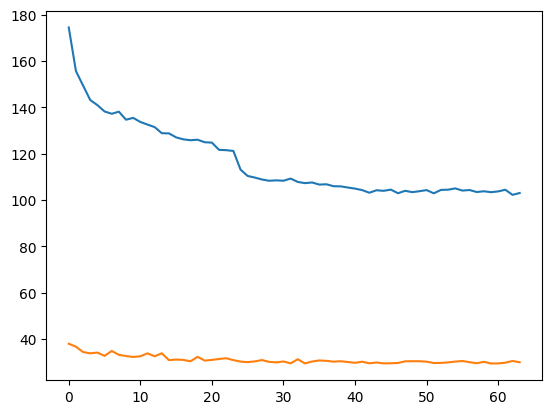

In [17]:
x = [i for i in range(0, epochs)]
plt.plot(x, loss_)
plt.plot(x, val_loss_)

In [18]:
len(val_loader)

68

In [20]:
correct = 0
total = 0

y_test = []
y_pred = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(encoder_net(inputs))
        _, predicted = torch.max(outputs.data, 1)
        # for auc curve 
        y_pred = np.append(y_pred, predicted.cpu().numpy())
        y_test = np.append(y_test, labels.cpu().numpy())

        correct += predicted.eq(labels.reshape(len(labels), )).sum()
        total += float(len(labels))
    accuracy = correct / total

    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.7983


In [ ]:
#torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CS520/CIS Final Project/cnn.pth')

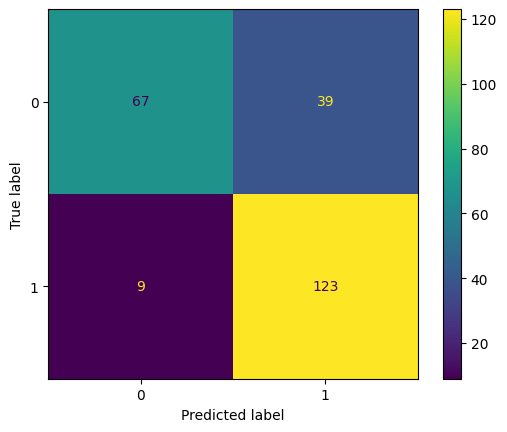

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

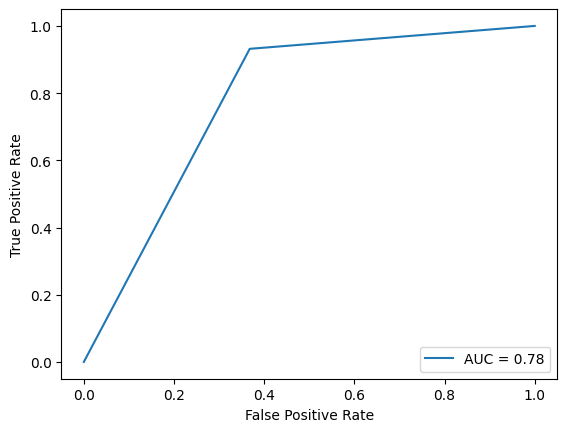

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

plt.show()